In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json


INT_SIZE =      32 // 8     # 32 // 8 = 4 bytes for int32
COMPLEX_SIZE =  128 // 8    # 128 // 8 = 16 bytes for complex<float64, float64>

MEMORY_SCALING = 10**-6 # MB
MEMORY_UNIT_STR = "MB"


In [90]:
def plot_qubits_by_time(df: pd.DataFrame):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x="qubits", y="time", hue="QC_version", marker="o")
    
    qubit_values = sorted(df['qubits'].unique())
    plt.xticks(ticks=qubit_values, labels=qubit_values)

    time_limit = df["time_limit"].unique()
    assert(len(time_limit) == 1)

    plt.axhline(y=time_limit, color='red', linestyle='--', alpha=0.6)

    plt.text(
        min(qubit_values),  # x position (far left)
        time_limit,  # y position (at the time limit)
        'Time Limit',  # Label text
        color='red',  # Text color
        verticalalignment='bottom',  # Position text below the line
        horizontalalignment='left',  # Align text to the left
        fontsize=12
    )
    
    plt.title("Execution Time by QC Version and Qubits")
    plt.xlabel("Number of Qubits")
    plt.ylabel("Execution Time (seconds)")
    plt.legend(title="QC Version")
    plt.grid()
    plt.show()


def plot_hadamards_by_time(df: pd.DataFrame):
    max_qubits_df = df.groupby("QC_version")["qubits"].max().reset_index()
    max_qubits_df = df.merge(max_qubits_df, on=["QC_version", "qubits"])
    max_qubits_df["normalized_time"] = max_qubits_df.groupby("QC_version")["time"].transform(
        lambda x: x / x.max() 
    )
    
    max_qubits_df["legend_label"] = max_qubits_df.apply(
        lambda row: f"{row['QC_version']} ({row['qubits']} qubits)", axis=1
    )
    
    # Drop duplicate labels to avoid multiple entries in the legend
    #unique_labels = max_qubits_df[["QC_version", "qubits", "legend_label"]].drop_duplicates()
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=max_qubits_df,
        x="hadamards",
        y="normalized_time",
        hue="legend_label",
        marker="o"
    )

    qubit_values = sorted(df['hadamards'].unique())
    plt.xticks(ticks=qubit_values, labels=qubit_values)
    
    # Add labels and title
    plt.title("Normalized Time vs. Hadamards")
    plt.xlabel("Number of Hadamards")
    plt.ylabel("Normalized Execution Time")
    plt.legend(title="QC Version")
    plt.grid()
    plt.show()


def plot_qubits_by_average_memory(df: pd.DataFrame):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x="qubits", y="average_memory", hue="QC_version", marker="o")
    
    qubit_values = sorted(df['qubits'].unique())
    plt.xticks(ticks=qubit_values, labels=qubit_values)
    
    plt.title("Average State Vector Size by QC Version and Qubits")
    plt.xlabel("Number of Qubits")
    plt.ylabel(f"{MEMORY_UNIT_STR}")
    plt.legend(title="QC Version")
    plt.grid()
    plt.show()



def plot_max_qubit_v3_memory(df: pd.DataFrame, target_qubit=None):
    # Filter the dataframe for QC_version == 'v3' and max(qubits)
    if target_qubit:
        max_qubits = target_qubit
    else:
        max_qubits = df.loc[df['QC_version'] == 'v3', 'qubits'].max()
    subset_df = df[(df['QC_version'] == 'v3') & (df['qubits'] == max_qubits)]
    
    # Expand the statevector_bytes_after_each_gate into long format
    long_data = []
    for _, row in subset_df.iterrows():
        hadamards = row['hadamards']
        bytes_data = row['statevector_bytes_after_each_gate']
        long_data.extend([(hadamards, byte_value) for byte_value in bytes_data])
    
    # Create a new dataframe for plotting
    long_df = pd.DataFrame(long_data, columns=['hadamards', 'statevector_bytes'])
    
    # Create the boxplot
    plt.figure(figsize=(10, 6))
    box_plot = sns.boxplot(
        data=long_df,
        x='hadamards',
        y='statevector_bytes',
        #showfliers=True,  # Include outliers
        #whis=[0, 100],    # Whiskers represent the min and max
        #palette="Set2",   # Use a visually distinct color palette
        linewidth=2       # Thicker lines for better visibility
    )
    
    # Customize the median line color and style
    for median_line in box_plot.artists:
        median_line.set_edgecolor('darkblue')
    
    # Highlight the median line with a custom color and thickness
    for line in box_plot.lines:
        line.set_color('darkblue')
        line.set_linewidth(2)
    

    ARRAY_MEMORY_SIZE = 2**max_qubits * COMPLEX_SIZE * MEMORY_SCALING
    plt.axhline(y=ARRAY_MEMORY_SIZE, color='red', linestyle='--', alpha=0.6)

    # Annotate the "time limit" label
    plt.text(
        min(long_df["hadamards"]),  # x position (far left)
        ARRAY_MEMORY_SIZE,  # y position (at the time limit)
        'State vector array size',  # Label text
        color='red',  # Text color
        verticalalignment='bottom',  # Position text below the line
        horizontalalignment='left',  # Align text to the left
        fontsize=12
    )
    
    # Customize the plot appearance
    plt.title(f"Statevector Size During QFT Depending On Number Of Hadamards Before QFT (QC_version='v3', {max_qubits} qubits)", fontsize=14)
    plt.xlabel("Number of Hadamards", fontsize=12)
    plt.ylabel(f"{MEMORY_UNIT_STR}", fontsize=12)
    #plt.xticks(fontsize=10)
    #plt.yticks(fontsize=10)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [91]:
df = pd.read_json("benchmark_data.json").T
display(df)
display(df.dtypes)

,QC_version,qubits,hadamards,time,time_limit,statevector_objects_after_each_gate
1,v1,3,0,0.000528,20.0,"[8, 8, 8, 8, 8, 8, 8, 8]"
2,v1,3,1,0.000278,20.0,"[8, 8, 8, 8, 8, 8, 8, 8]"
3,v1,3,2,0.000268,20.0,"[8, 8, 8, 8, 8, 8, 8, 8]"
4,v1,3,3,0.000262,20.0,"[8, 8, 8, 8, 8, 8, 8, 8]"
5,v1,4,0,0.000609,20.0,"[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1..."
...,...,...,...,...,...,...
589,v3,21,17,33.136325,20.0,"[131072, 262144, 262144, 262144, 262144, 26214..."
590,v3,21,18,34.092259,20.0,"[262144, 524288, 524288, 524288, 524288, 52428..."
591,v3,21,19,32.25691,20.0,"[524288, 1048576, 1048576, 1048576, 1048576, 1..."
592,v3,21,20,23.317056,20.0,"[1048576, 2097152, 2097152, 2097152, 2097152, ..."


QC_version                             object
qubits                                 object
hadamards                              object
time                                   object
time_limit                             object
statevector_objects_after_each_gate    object
dtype: object

In [92]:
df = df.astype({
    "QC_version": str,
    "qubits": int,
    "hadamards": int,
    "time": float,
    "time_limit": float,
})

display(df.dtypes)

QC_version                              object
qubits                                   int64
hadamards                                int64
time                                   float64
time_limit                             float64
statevector_objects_after_each_gate     object
dtype: object

In [93]:
bytes_conversion = lambda row: [
    (COMPLEX_SIZE + INT_SIZE) * num_objects * MEMORY_SCALING if row["QC_version"] == "v3" \
        else COMPLEX_SIZE * num_objects * MEMORY_SCALING \
        for num_objects in row["statevector_objects_after_each_gate"]
]

df["statevector_bytes_after_each_gate"] = df.apply(bytes_conversion, axis=1)
display(df[["statevector_objects_after_each_gate", "statevector_bytes_after_each_gate"]])

display(df.dtypes)

,statevector_objects_after_each_gate,statevector_bytes_after_each_gate
1,"[8, 8, 8, 8, 8, 8, 8, 8]","[0.000128, 0.000128, 0.000128, 0.000128, 0.000..."
2,"[8, 8, 8, 8, 8, 8, 8, 8]","[0.000128, 0.000128, 0.000128, 0.000128, 0.000..."
3,"[8, 8, 8, 8, 8, 8, 8, 8]","[0.000128, 0.000128, 0.000128, 0.000128, 0.000..."
4,"[8, 8, 8, 8, 8, 8, 8, 8]","[0.000128, 0.000128, 0.000128, 0.000128, 0.000..."
5,"[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1...","[0.000256, 0.000256, 0.000256, 0.000256, 0.000..."
...,...,...
589,"[131072, 262144, 262144, 262144, 262144, 26214...","[2.6214399999999998, 5.2428799999999995, 5.242..."
590,"[262144, 524288, 524288, 524288, 524288, 52428...","[5.2428799999999995, 10.485759999999999, 10.48..."
591,"[524288, 1048576, 1048576, 1048576, 1048576, 1...","[10.485759999999999, 20.971519999999998, 20.97..."
592,"[1048576, 2097152, 2097152, 2097152, 2097152, ...","[20.971519999999998, 41.943039999999996, 41.94..."


QC_version                              object
qubits                                   int64
hadamards                                int64
time                                   float64
time_limit                             float64
statevector_objects_after_each_gate     object
statevector_bytes_after_each_gate       object
dtype: object

In [94]:
df["median_memory"] = df.apply(lambda row: np.median(row["statevector_bytes_after_each_gate"]), axis=1)

df["average_memory"] = df.apply(lambda row: np.mean(row["statevector_bytes_after_each_gate"]), axis=1)

display(df[["qubits", "median_memory", "average_memory"]])

display(df.dtypes)

display(df.columns)

,qubits,median_memory,average_memory
1,3,0.000128,0.000128
2,3,0.000128,0.000128
3,3,0.000128,0.000128
4,3,0.000128,0.000128
5,4,0.000256,0.000256
...,...,...,...
589,21,39.331840,32.757169
590,21,36.741120,33.775414
591,21,31.539200,32.107225
592,21,21.299200,24.437888


QC_version                              object
qubits                                   int64
hadamards                                int64
time                                   float64
time_limit                             float64
statevector_objects_after_each_gate     object
statevector_bytes_after_each_gate       object
median_memory                          float64
average_memory                         float64
dtype: object

Index(['QC_version', 'qubits', 'hadamards', 'time', 'time_limit',
       'statevector_objects_after_each_gate',
       'statevector_bytes_after_each_gate', 'median_memory', 'average_memory'],
      dtype='object')

In [95]:
max_performance_df = pd.read_json("benchmark_max_performance_data.json").T
display(max_performance_df)
display(max_performance_df.dtypes)

,QC_version,qubits,hadamards,time,time_limit,statevector_objects_after_each_gate
1,v3,3,3,0.000022,20.0,"[8, 4, 4, 4, 2, 2, 1, 1]"
2,v3,4,4,0.000023,20.0,"[16, 8, 8, 8, 8, 4, 4, 4, 2, 2, 1, 1, 1]"
3,v3,5,5,0.00003,20.0,"[32, 16, 16, 16, 16, 16, 8, 8, 8, 8, 4, 4, 4, ..."
4,v3,6,6,0.000038,20.0,"[64, 32, 32, 32, 32, 32, 32, 16, 16, 16, 16, 1..."
5,v3,7,7,0.000068,20.0,"[128, 64, 64, 64, 64, 64, 64, 64, 32, 32, 32, ..."
6,v3,8,8,0.000116,20.0,"[256, 128, 128, 128, 128, 128, 128, 128, 128, ..."
7,v3,9,9,0.000217,20.0,"[512, 256, 256, 256, 256, 256, 256, 256, 256, ..."
8,v3,10,10,0.000421,20.0,"[1024, 512, 512, 512, 512, 512, 512, 512, 512,..."
9,v3,11,11,0.000831,20.0,"[2048, 1024, 1024, 1024, 1024, 1024, 1024, 102..."
10,v3,12,12,0.001671,20.0,"[4096, 2048, 2048, 2048, 2048, 2048, 2048, 204..."


QC_version                             object
qubits                                 object
hadamards                              object
time                                   object
time_limit                             object
statevector_objects_after_each_gate    object
dtype: object

In [96]:
max_performance_df = max_performance_df.astype({
    "QC_version": str,
    "qubits": int,
    "hadamards": int,
    "time": float,
    "time_limit": float,
})

display(max_performance_df.dtypes)

QC_version                              object
qubits                                   int64
hadamards                                int64
time                                   float64
time_limit                             float64
statevector_objects_after_each_gate     object
dtype: object

In [97]:
max_performance_df["statevector_bytes_after_each_gate"] = max_performance_df.apply(bytes_conversion, axis=1)
display(max_performance_df[["statevector_objects_after_each_gate", "statevector_bytes_after_each_gate"]])

display(max_performance_df.dtypes)

,statevector_objects_after_each_gate,statevector_bytes_after_each_gate
1,"[8, 4, 4, 4, 2, 2, 1, 1]","[0.00015999999999999999, 7.999999999999999e-05..."
2,"[16, 8, 8, 8, 8, 4, 4, 4, 2, 2, 1, 1, 1]","[0.00031999999999999997, 0.0001599999999999999..."
3,"[32, 16, 16, 16, 16, 16, 8, 8, 8, 8, 4, 4, 4, ...","[0.0006399999999999999, 0.00031999999999999997..."
4,"[64, 32, 32, 32, 32, 32, 32, 16, 16, 16, 16, 1...","[0.0012799999999999999, 0.0006399999999999999,..."
5,"[128, 64, 64, 64, 64, 64, 64, 64, 32, 32, 32, ...","[0.0025599999999999998, 0.0012799999999999999,..."
6,"[256, 128, 128, 128, 128, 128, 128, 128, 128, ...","[0.0051199999999999996, 0.0025599999999999998,..."
7,"[512, 256, 256, 256, 256, 256, 256, 256, 256, ...","[0.010239999999999999, 0.0051199999999999996, ..."
8,"[1024, 512, 512, 512, 512, 512, 512, 512, 512,...","[0.020479999999999998, 0.010239999999999999, 0..."
9,"[2048, 1024, 1024, 1024, 1024, 1024, 1024, 102...","[0.040959999999999996, 0.020479999999999998, 0..."
10,"[4096, 2048, 2048, 2048, 2048, 2048, 2048, 204...","[0.08191999999999999, 0.040959999999999996, 0...."


QC_version                              object
qubits                                   int64
hadamards                                int64
time                                   float64
time_limit                             float64
statevector_objects_after_each_gate     object
statevector_bytes_after_each_gate       object
dtype: object

In [98]:
max_performance_df["median_memory"] = max_performance_df\
    .apply(lambda row: np.median(row["statevector_bytes_after_each_gate"]), axis=1)

max_performance_df["average_memory"] = max_performance_df\
    .apply(lambda row: np.mean(row["statevector_bytes_after_each_gate"]), axis=1)

display(max_performance_df[["qubits", "median_memory", "average_memory"]])

display(max_performance_df.dtypes)

display(max_performance_df.columns)

,qubits,median_memory,average_memory
1,3,0.00006,0.000065
2,4,0.00008,0.000103
3,5,0.00016,0.000181
4,6,0.00016,0.000310
5,7,0.00032,0.000562
6,8,0.00064,0.001001
7,9,0.00096,0.001845
8,10,0.00128,0.003359
9,11,0.00256,0.006259
10,12,0.00512,0.011567


QC_version                              object
qubits                                   int64
hadamards                                int64
time                                   float64
time_limit                             float64
statevector_objects_after_each_gate     object
statevector_bytes_after_each_gate       object
median_memory                          float64
average_memory                         float64
dtype: object

Index(['QC_version', 'qubits', 'hadamards', 'time', 'time_limit',
       'statevector_objects_after_each_gate',
       'statevector_bytes_after_each_gate', 'median_memory', 'average_memory'],
      dtype='object')

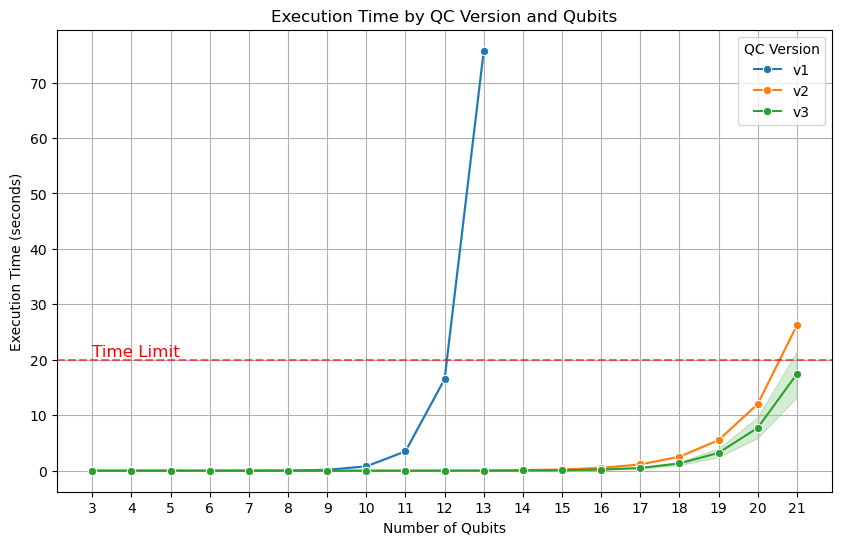

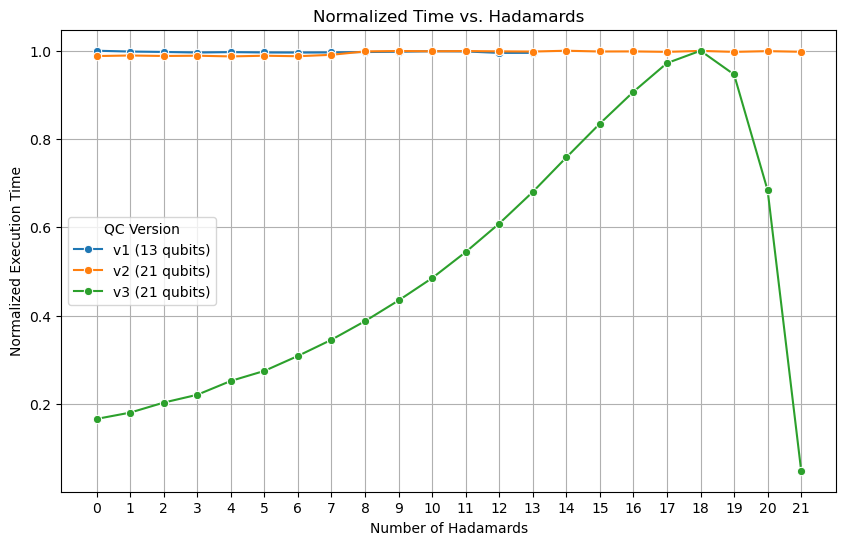

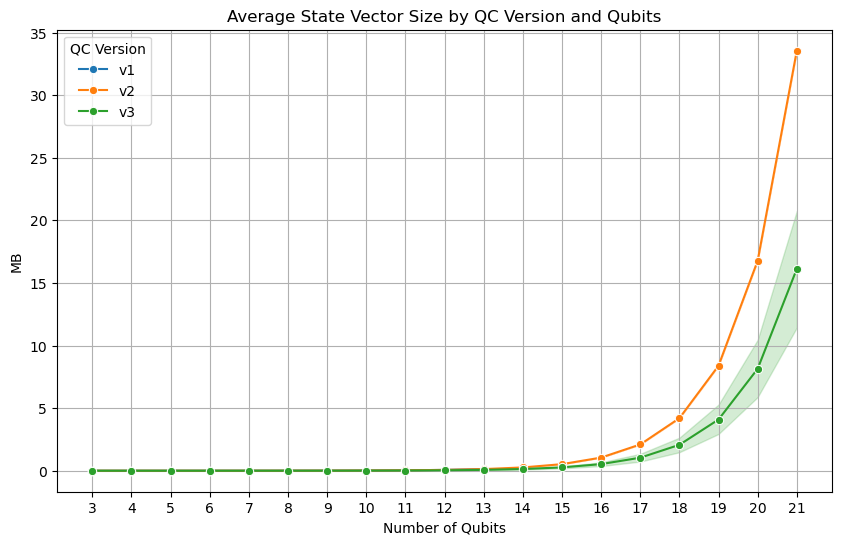

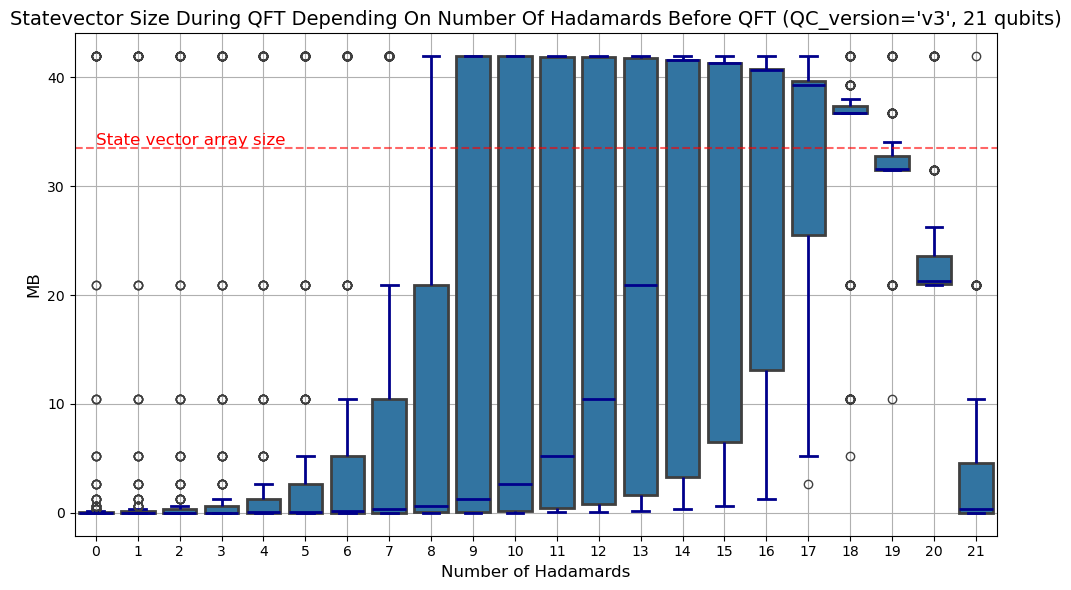

In [99]:
plot_qubits_by_time(df)

plot_hadamards_by_time(df)

plot_qubits_by_average_memory(df)

plot_max_qubit_v3_memory(df)

In [100]:
df_v1_and_v2 = df[df["QC_version"] != "v3"]
# df_v1_and_v2 = pd.concat([df_v1_and_v2, max_performance_df])
# display(df_v1_and_v2)

# plot_qubits_by_time(df_v1_and_v2)

# # plot_hadamards_by_time(df)

# plot_qubits_by_average_memory(max_performance_df)

# plot_max_qubit_v3_memory(df)

/var/folders/wm/pbcyrfv14zlcs5yvlwwjd1p00000gn/T/ipykernel_91111/1446666468.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v3_bad["QC_version"] = "v3, average"


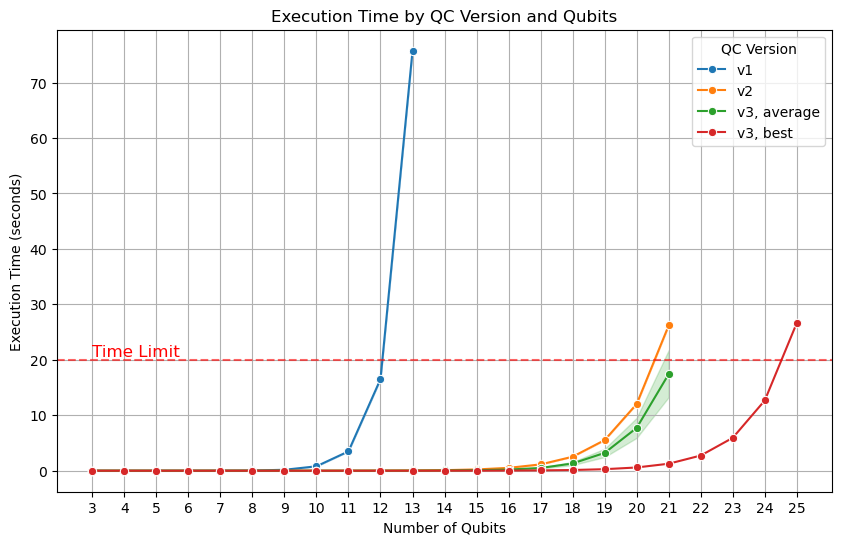

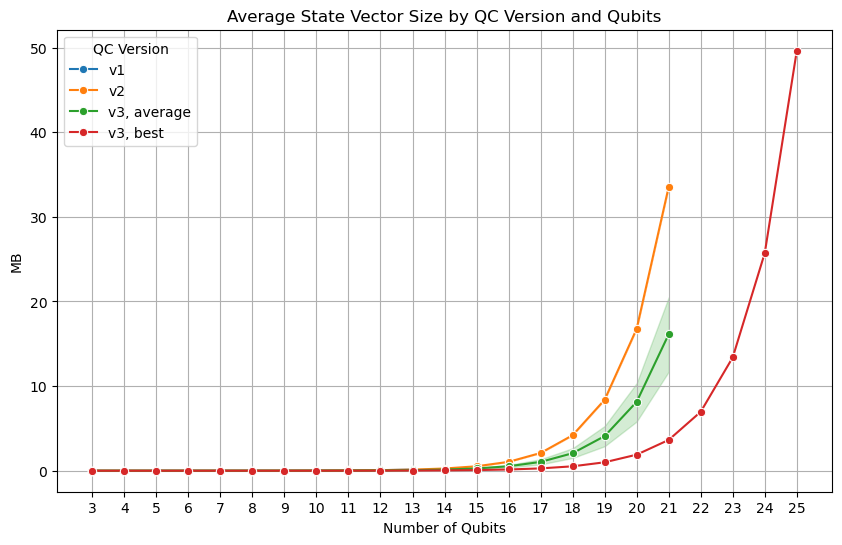

In [101]:
df_v3_bad = df[df["QC_version"] == "v3"]
df_v3_bad["QC_version"] = "v3, average"

df_v3_good = max_performance_df
df_v3_good["QC_version"] = "v3, best"


# df_v3 = pd.concat([df_v3_bad, df_v3_good])

# df_v3.sort_values("QC_version", inplace=True)

# display(df_v3)


# # df_v1_and_v2 = pd.concat([df_v1_and_v2, max_performance_df])
# # display(df_v1_and_v2)

# plot_qubits_by_time(df_v3)

# plot_qubits_by_average_memory(df_v3)



df_v3 = pd.concat([df_v3_bad, df_v3_good, df_v1_and_v2])
df_v3.sort_values("QC_version", inplace=True)

plot_qubits_by_time(df_v3)

plot_qubits_by_average_memory(df_v3)